# Business Goal

The telecome operator Megaline seeks to analyze its two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget.

We will use a sample of 500 Megaline clients to analyze the clients' behavior and determine which prepaid plan brings in more revenue. We will analyze data on usage of calls, message and internet data to explore the monthly usage for users of each plan and to determine if there are any differences between users of the plans. We will also explore differences in the monthly revenue and overall revenue for users of each plan to determine if there is a significant difference in revenue between plans.

# Initialization

In [84]:
# Loading all the libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

## Load Data

In [85]:
# Load the data files

plans_data = pd.read_csv('megaline_plans.csv')
users_data = pd.read_csv('megaline_users.csv')
calls_data = pd.read_csv('megaline_calls.csv')
messages_data = pd.read_csv('megaline_messages.csv')
internet_data = pd.read_csv('megaline_internet.csv')

# Data Preprocessing

The data is split into four dataframes. We will explore each one and preprocess the data.

## Plans

In [86]:
plans_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [87]:
plans_data.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


The plans table provides data on two plans: surf and ultimate.
There are 2 rows, containing 8 columns with the specifics for each plan.

 - messages_included — monthly text allowance
 - mb_per_month_included — data volume allowance (in megabytes) - equal to 15 GB
 - minutes_included — monthly minute allowance
 - usd_monthly_pay — monthly charge in US dollars
 - usd_per_gb — price per extra gigabyte of data after exceeding the package limits (1 GB = 1024 megabytes)
 - usd_per_message — price per text after exceeding the package limits
 - usd_per_minute — price per minute after exceeding the package limits (e.g., if the package includes 100 minutes, the 101st minute will be charged)
 - plan_name — calling plan name

The plan is an object datatype and most of the columns are integers. We need to change the column 'plan_name' to 'plan' so that it matches the similar column for the users_data and we can merge these dataframes for future analysis.

Note: usd_per_message and usd_per_minute are float types. We need to keep these as float types because they signify revenue of less than a dollar.
There are no missing values.
In the analysis, we will need to calculate monthly revenue using the internet data in the form of gb. Since data usage is rounded up per month after each 1024 mb used, we will convert this to gb later in the analysis after aggregating the data per month.

### Plans Data Preprocessing

In [88]:
# Renaming 'plan_name' to 'plan' for future analysis

plans_data.rename(columns = {'plan_name':'plan'}, inplace = True)

## Users

In [89]:
# Print the general/summary information about the users' DataFrame

users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [90]:
# Print a sample of data for users

users_data.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


The users table (data on users) has 8 columns with information on 500 user_ids:

 - user_id — unique user identifier
 - first_name — user's name
 - last_name — user's last name
 - age — user's age (years)
 - reg_date — subscription date (dd, mm, yy)
 - churn_date — the date the user stopped using the service (if the value is missing, the calling plan was being used when this database was extracted)
 - city — user's city of residence
 - plan — calling plan name

The user_id is represented by an integer. Age is an integer. All other columns are object types (first_name, last_name, city, reg_date, plan, churn_date.) 
The reg_date and churn_date need to be converted to datetime types.
There are missing values in churn_date, which means the plan was being used when the data was extracted. If we replace these missing values with 'active' to indicate the user never stopped the service we will not be able to convert the column values to a datetime because there will be string values so we will leave it as is.

### User Data Preprocessing

In [91]:
# Changing reg_date and churn_date to datetime value
 
users_data['reg_date'] = pd.to_datetime(users_data['reg_date'], format='%Y-%m-%d')
users_data['churn_date'] = pd.to_datetime(users_data['churn_date'], format='%Y-%m-%d')

In [92]:
# Checking that datetime value was assigned and missing values were replaced
users_data.info()
users_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaT
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaT
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaT


## Calls

In [93]:
# Print the general/summary information about the calls' DataFrame

calls_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [94]:
# Print a sample of data for calls

calls_data.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


The calls_data has four columns, and 137735 rows:
 - id — unique call identifier
 - call_date — call date
 - duration — call duration (in minutes)
 - user_id — the identifier of the user making the call

The id is an object type and the user_id is an integer. It may not make a difference but they should be consistent. Let's change the id type to an integer type. Also, since we need to merge dataframes that contain id for different meanings, let's rename id as call_id.
The call_date needs to be changed from an object to a datetime type.
The duration is a float type. Megaline rounds seconds up to minutes. For calls, each individual call is rounded up: even if the call lasted just one second, it will be counted as one minute. So we should change this to an integer type after rounding each number up to the nearest minute. If we changed it to an integer type before it would round each number down to the nearest whole number.
There are no missing values.

### Call Data Preprocessing

In [95]:
# Changing id to an integer type
calls_data['id'] = calls_data['id'].astype(int)

In [96]:
# Renaming the column 'id' to 'call_id'
calls_data.rename(columns = {'id':'call_id'}, inplace = True)

In [97]:
# Changing call_date to datetime type
calls_data['call_date'] = pd.to_datetime(calls_data['call_date'], format='%Y-%m-%d')

In [98]:
#Rounding values in 'duration' up to the nearest integer and converting to integer

calls_data['duration'] = np.ceil(calls_data['duration'])
calls_data['duration'] = calls_data['duration'].astype(int)

In [99]:
#Checking column values
calls_data.info()
calls_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   call_id    137735 non-null  int32         
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  int32         
dtypes: datetime64[ns](1), int32(2), int64(1)
memory usage: 3.2 MB


,call_id,user_id,call_date,duration
0,100093,1000,2018-12-27,9
1,1000145,1000,2018-12-27,14
2,1000247,1000,2018-12-27,15
3,1000309,1000,2018-12-28,6
4,1000380,1000,2018-12-30,5


### Enrich Call Data

In order to calculate monthly revenue, we need to create a month column for calls_data so that in our analyses we can sum all the calls per month per user.

In [100]:
# Creating a column for 'month' in calls_data

calls_data['month'] = pd.DatetimeIndex(calls_data['call_date']).month

In [101]:
# Checking calls_data for changes
calls_data.head()

,call_id,user_id,call_date,duration,month
0,100093,1000,2018-12-27,9,12
1,1000145,1000,2018-12-27,14,12
2,1000247,1000,2018-12-27,15,12
3,1000309,1000,2018-12-28,6,12
4,1000380,1000,2018-12-30,5,12


## Messages

In [102]:
# Print the general/summary information about the messages' DataFrame

messages_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [103]:
# Print a sample of data for messages

messages_data.head()

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


The messages table (data on texts) has 76051 entries.
id — unique text message identifier
message_date — text message date
user_id — the identifier of the user sending the text

The id is an object type. Let's convert this to an integer. Let's also rename this column from 'id' to 'message_id' so it will be clear and distinct from 'call_id'.
The message_date needs to be converted from an object type to a datetime type.
There are no missing values.

### Message Data Preprocessing

In [104]:
# Renaming the column 'id' to 'message_id'
messages_data.rename(columns = {'id':'message_id'}, inplace = True)

In [105]:
# Converting message_id to an integer type
messages_data['message_id'] = messages_data['message_id'].astype(int)

In [106]:
# Converting message_date to a datetime type
messages_data['message_date'] = pd.to_datetime(messages_data['message_date'], format='%Y-%m-%d')

In [107]:
#Checking columns in messages_data
messages_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   message_id    76051 non-null  int32         
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int32(1), int64(1)
memory usage: 1.5 MB


In [108]:
# Creating a column for 'month' in messages_data

messages_data['month'] = pd.DatetimeIndex(messages_data['message_date']).month
messages_data.head()

,message_id,user_id,message_date,month
0,1000125,1000,2018-12-27,12
1,1000160,1000,2018-12-31,12
2,1000223,1000,2018-12-31,12
3,1000251,1000,2018-12-27,12
4,1000255,1000,2018-12-26,12


## Internet

In [109]:
# Print the general/summary information about the internet DataFrame

internet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [110]:
# Print a sample of data for the internet traffic

internet_data.head()

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


The internet table (data on web sessions) has 4 columns, 104825 entries.

 - id — unique session identifier
 - mb_used — the volume of data spent during the session (in megabytes)
 - session_date — web session date
 - user_id — user identifier

There are no missing values.
The id is an object type. Let's convert this to an integer. The session_date needs to be converted from an object type to a datetime type.
The mb_used is a float type. It is important to note that mb_used represents the volume of data spent during a session (in megabytes). At Megaline, for web traffic, individual web sessions are not rounded up. Instead, the total gb for the month is rounded up. So after we aggregated the date per month, we will need to calculate monthly charges for extra data based on rate of $10 per 1 GB of data. If someone uses 1025 megabytes this month, they will be charged for 2 gigabytes. We will create a column 'gb_used' later on  to calculate internet usage for future analysis.

### Internet Data Preprocessing

In [111]:
# Converting id to an integer type and session_date to a datetime type

internet_data['id'] = internet_data['id'].astype(int)

internet_data['session_date'] = pd.to_datetime(internet_data['session_date'], format='%Y-%m-%d')

#Checking columns in internet_data
internet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  int32         
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1)
memory usage: 2.8 MB


### Enrich Internet Data

Let's create a month colum for internet_data to be used for future analysis.

In [112]:
# Creating a column for 'month' in internet_data

internet_data['month'] = pd.DatetimeIndex(internet_data['session_date']).month
internet_data.head()

,id,user_id,session_date,mb_used,month
0,100013,1000,2018-12-29,89.86,12
1,1000204,1000,2018-12-31,0.00,12
2,1000379,1000,2018-12-28,660.40,12
3,1000413,1000,2018-12-26,270.99,12
4,1000442,1000,2018-12-27,880.22,12


In [113]:
# Checking internet_data after changes

internet_data.head()

,id,user_id,session_date,mb_used,month
0,100013,1000,2018-12-29,89.86,12
1,1000204,1000,2018-12-31,0.00,12
2,1000379,1000,2018-12-28,660.40,12
3,1000413,1000,2018-12-26,270.99,12
4,1000442,1000,2018-12-27,880.22,12


Now we have a column 'gb_used' to use for calculating monthly revenue below.

## Study Plan Conditions

In [114]:
plans_data.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


## Aggregate Data Per User


We need to aggregate the data per user into one dataframe for future analysis.

In [115]:
# Calculate the number of calls made by each user per month. Save the result.

user_calls = calls_data.pivot_table(index = ('user_id','month'), values = 'call_id', aggfunc = ('count'))

user_calls.head()

call_id
user_id month         
1000    12          16
1001    8           27
        9           49
        10          65
        11          64

In [116]:
# Calculate the number of calls and the number of minutes made by each user per month. Save the result.

user_minutes = calls_data.pivot_table(index = ('user_id','month'), values = 'duration', aggfunc = ('sum'))
user_minutes.head()

duration
user_id month          
1000    12          124
1001    8           182
        9           315
        10          393
        11          426

In [117]:
# Calculate the number of messages sent by each user per month. Save the result.

user_messages = messages_data.pivot_table(index=('user_id', 'month'), values= 'message_id', aggfunc='count')
user_messages.head()

message_id
user_id month            
1000    12             11
1001    8              30
        9              44
        10             53
        11             36

In [118]:
# Calculate the volume of internet traffic used by each user per month. Save the result.

user_internet = internet_data.pivot_table(index=('user_id', 'month'), values= 'mb_used', aggfunc='sum')
user_internet.head()

mb_used
user_id month          
1000    12      1901.47
1001    8       6919.15
        9      13314.82
        10     22330.49
        11     18504.30

Putting the aggregate data together into one DataFrame so that one record in it would represent what an unique user consumed in a given month.

In [119]:
# Merge the data for calls, minutes, messages, internet based on user_id and month

merge1 = user_calls.merge(user_minutes, on=['user_id', 'month'], how='left')
merge2 = merge1.merge(user_messages, on=['user_id', 'month'], how='outer')
merge3 = merge2.reset_index().merge(user_internet, on=['user_id', 'month'], how='outer')

merge3.info()
merge3.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   user_id     2293 non-null   int64  
 1   month       2293 non-null   int64  
 2   call_id     2258 non-null   float64
 3   duration    2258 non-null   float64
 4   message_id  1806 non-null   float64
 5   mb_used     2277 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 125.4 KB


,user_id,month,call_id,duration,message_id,mb_used
0,1000,12,16.0,124.0,11.0,1901.47
1,1001,8,27.0,182.0,30.0,6919.15
2,1001,9,49.0,315.0,44.0,13314.82
3,1001,10,65.0,393.0,53.0,22330.49
4,1001,11,64.0,426.0,36.0,18504.30
5,1001,12,56.0,412.0,44.0,19369.18
6,1002,10,11.0,59.0,15.0,6552.01
7,1002,11,55.0,386.0,32.0,19345.08
8,1002,12,47.0,384.0,41.0,14396.24
9,1003,12,149.0,1104.0,50.0,27044.14


In [120]:
#Merging users_data with users usage info
              
merge4 = merge3.reset_index().merge(users_data, on='user_id', how='right')
merge4.info()
merge4.head() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2303 entries, 0 to 2302
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   index       2293 non-null   float64       
 1   user_id     2303 non-null   int64         
 2   month       2293 non-null   float64       
 3   call_id     2258 non-null   float64       
 4   duration    2258 non-null   float64       
 5   message_id  1806 non-null   float64       
 6   mb_used     2277 non-null   float64       
 7   first_name  2303 non-null   object        
 8   last_name   2303 non-null   object        
 9   age         2303 non-null   int64         
 10  city        2303 non-null   object        
 11  reg_date    2303 non-null   datetime64[ns]
 12  plan        2303 non-null   object        
 13  churn_date  160 non-null    datetime64[ns]
dtypes: datetime64[ns](2), float64(6), int64(2), object(4)
memory usage: 269.9+ KB


,index,user_id,month,call_id,duration,message_id,mb_used,first_name,last_name,age,city,reg_date,plan,churn_date
0,0.0,1000,12.0,16.0,124.0,11.0,1901.47,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT
1,1.0,1001,8.0,27.0,182.0,30.0,6919.15,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT
2,2.0,1001,9.0,49.0,315.0,44.0,13314.82,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT
3,3.0,1001,10.0,65.0,393.0,53.0,22330.49,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT
4,4.0,1001,11.0,64.0,426.0,36.0,18504.30,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT


In [121]:
# Add the plan information

users = merge4.merge(plans_data, on='plan', how='left')
users.head()

,index,user_id,month,call_id,duration,message_id,mb_used,first_name,last_name,age,city,reg_date,plan,churn_date,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
0,0.0,1000,12.0,16.0,124.0,11.0,1901.47,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT,1000,30720,3000,70,7,0.01,0.01
1,1.0,1001,8.0,27.0,182.0,30.0,6919.15,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,50,15360,500,20,10,0.03,0.03
2,2.0,1001,9.0,49.0,315.0,44.0,13314.82,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,50,15360,500,20,10,0.03,0.03
3,3.0,1001,10.0,65.0,393.0,53.0,22330.49,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,50,15360,500,20,10,0.03,0.03
4,4.0,1001,11.0,64.0,426.0,36.0,18504.30,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,50,15360,500,20,10,0.03,0.03


There are NaN values in the message_id column indicating 0 usage per user per period. Let's fill in these missing values with 0 to indicate no usage.

In [122]:
# Filling in missing values in message_id with 0

users['message_id']= users['message_id'].fillna(0)

Now that we have one dataframe with all of the information per user per month, we need to calculate the extra internet used per month so that we can include this in our calculation of monthly revenue per user. At Megaline, the total for the month is rounded up. If someone uses 1025 megabytes this month over the standard GB included in the plan, they will be charged for 2 gigabytes.

In [123]:
# Calculating extra GB used per month

def internet(users):
    for user in users:
        if users['mb_used'] > users['mb_per_month_included']:
            gb_used = (users['mb_used'] - users['mb_per_month_included'])/1024
        else:
            gb_used = 0
            
        return gb_used

In [124]:
# Applying the function to create a new column 'gb_used' with 'gb_used' rounded up
users['gb_used'] = users.apply(internet, axis=1)
users['gb_used'] = np.ceil(users['gb_used'])            
users.head()

,index,user_id,month,call_id,duration,message_id,mb_used,first_name,last_name,age,city,reg_date,plan,churn_date,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,gb_used
0,0.0,1000,12.0,16.0,124.0,11.0,1901.47,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT,1000,30720,3000,70,7,0.01,0.01,0.0
1,1.0,1001,8.0,27.0,182.0,30.0,6919.15,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,50,15360,500,20,10,0.03,0.03,0.0
2,2.0,1001,9.0,49.0,315.0,44.0,13314.82,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,50,15360,500,20,10,0.03,0.03,0.0
3,3.0,1001,10.0,65.0,393.0,53.0,22330.49,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,50,15360,500,20,10,0.03,0.03,7.0
4,4.0,1001,11.0,64.0,426.0,36.0,18504.30,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,50,15360,500,20,10,0.03,0.03,4.0


Now that we have created one table with user specific information, we can calculate the monthly revenue for each user. To do this, we need to take into account the plan the user is on and calculate the standard charges plus the additional charges for usage above the plan limits. 
Let's create a function to calculate monthly revenue for each user per plan.

In [125]:
# Calculating the monthly revenue for each user

def monthly_revenue(users):

    for user_id in users:
        #add monthly charge
        monthly_charge = users['usd_monthly_pay']
        
        #add extra minutes charge
        if (users['duration'] > users['minutes_included']):
            xminutes_charge = (users['duration'] - users['minutes_included']) * (users['usd_per_minute'])
        else:
            xminutes_charge = 0
            
        #add extra text messages charge
        if (users['message_id'] > users['messages_included']):
            xmessages_charge = (users['message_id'] - users['messages_included']) * (users['usd_per_message'])
        else:
            xmessages_charge = 0
            
        #add extra data charge    
        if (users['gb_used'] > 0):
            xinternet_charge = (users['gb_used']) * (users['usd_per_gb']) 
        else:
            xinternet_charge = 0
            
        #total monthly revenue  
        revenue = monthly_charge + xminutes_charge + xmessages_charge + xinternet_charge
        
        return revenue

In [126]:
pd.set_option ('display.max_columns', None)

In [127]:
users['monthly_revenue'] = users.apply(monthly_revenue, axis=1)
users.head()

,index,user_id,month,call_id,duration,message_id,mb_used,first_name,last_name,age,city,reg_date,plan,churn_date,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,gb_used,monthly_revenue
0,0.0,1000,12.0,16.0,124.0,11.0,1901.47,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT,1000,30720,3000,70,7,0.01,0.01,0.0,70.00
1,1.0,1001,8.0,27.0,182.0,30.0,6919.15,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,50,15360,500,20,10,0.03,0.03,0.0,20.00
2,2.0,1001,9.0,49.0,315.0,44.0,13314.82,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,50,15360,500,20,10,0.03,0.03,0.0,20.00
3,3.0,1001,10.0,65.0,393.0,53.0,22330.49,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,50,15360,500,20,10,0.03,0.03,7.0,90.09
4,4.0,1001,11.0,64.0,426.0,36.0,18504.30,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,50,15360,500,20,10,0.03,0.03,4.0,60.00


## Study User Behaviour

Now that we have the monthly revenue calculated per user and the rest of the data in one table, we can explore the data. Since our goal is to compare the plans and decide which is more profitable, we need to calculate the statistics and plots on a per-plan basis.

### Calls

Let's explore call usage per plan per month.

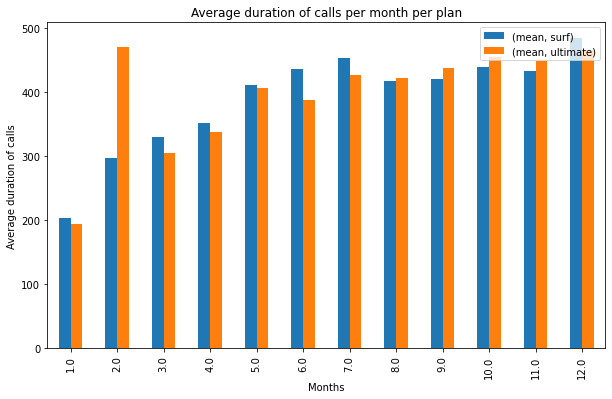

In [128]:
# Comparing average duration of calls per month per plan.

users.pivot_table(index='month',columns='plan', values = 'duration', aggfunc=['mean']).plot(kind='bar', figsize=(10, 6))

plt.xlabel("Months")
plt.ylabel("Average duration of calls")
plt.title("Average duration of calls per month per plan")
plt.legend(loc='upper right')
plt.show()

The average duration of calls per month varied across months for each plan. The mean duration tended to get higher from January to December for both plans. However, the average duration of calls for 'ultimate' was particularly high for February. 

Let's split users by plan and explore the data for each plan separately. This was help us understand if the data on call duration is significantly affected by outliers before we proceed with our analysis.

In [129]:
# Splitting the data based on plan: surf and ultimate
surf = users[(users['plan'] == 'surf')]
ultimate = users[(users['plan'] == 'ultimate')]

In [130]:
ultimate['duration'].describe()

count     713.000000
mean      434.676017
std       237.852123
min         0.000000
25%       263.000000
50%       425.000000
75%       566.000000
max      1369.000000
Name: duration, dtype: float64

In [131]:
surf['duration'].describe()

count    1545.000000
mean      436.519741
std       229.283805
min         0.000000
25%       279.000000
50%       430.000000
75%       579.000000
max      1510.000000
Name: duration, dtype: float64

The mean call duration for ultimate users was 434 and the median was 425. The mean call duration for surf users was 436 and the median was 430. These mean and median values per plan are close so it looks like the distribution of values for call duration was not significantly affected by outliers.

Let's compare the  number of minutes users of each plan require each month. We will need to calculate the number of extra minutes above the standard minutes included in the plan and create a column for these minutes. We will then plot a histogram displaying the minutes required for each plan.

In [132]:
# Creating a column for 'minutes_required' using a function

def xminutes(users):

    for user_id in users:
     
        if (users['duration'] > users['minutes_included']):
            xminutes = (users['duration'] - users['minutes_included'])
        else:
            xminutes = 0

        return round(xminutes)

In [133]:
# Applying 'xminutes' function to users and creating a column 'xminutes' to store the data
users['xminutes'] = users.apply(xminutes, axis=1)

Now we have an 'xminutes' column in users with a record of how many extra minutes each user needed per month. Let's plot this data per plan.

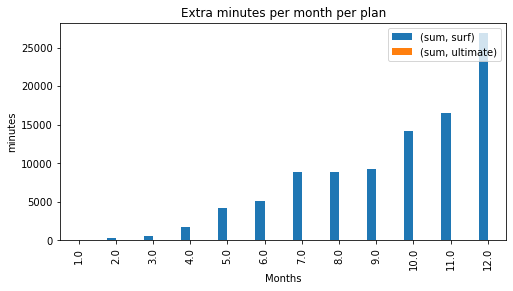

In [134]:
# Plotting 'xminutes' per month per plan using barplot

users.pivot_table(index='month',columns='plan', values ='xminutes', aggfunc=['sum']).plot(kind='bar', figsize=(8, 4))

plt.xlabel("Months")
plt.ylabel("minutes")
plt.title("Extra minutes per month per plan")
plt.legend(loc='upper right')
plt.show()

The extra minutes required per month were different for each plan. For surf, an increasing number of extra minutes were required as the year progressed from January to December. Yet, ultimate users generally did not need extra minutes. This makes sense since ultimate users had 3000 minutes included on the standard plan, while surf had only 500 minutes.

Let's use a histogram to plot the frequency of these values for xminutes per plan and check the distribution. We will create a function to plot these histograms.

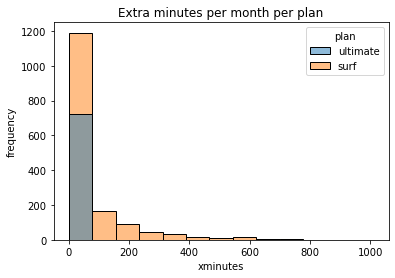

In [135]:
# Plotting the variance of 'xminutes' per plan using a histogram

sns.histplot(users, x='xminutes', hue='plan')
plt.xlabel("xminutes")
plt.ylabel("frequency")
plt.title("Extra minutes per month per plan")
plt.show()

There was a big difference between extra minutes required for each plan. The surf plan members tended to require more extra minutes than ultimate users. Surf users mostly used less than 200 extra minutes but they may have used over 700 extra minutes. However, ultimate users who require extra minutes tended to need less than 100 minutes.

Let's explore call duration further. We will plot a histogram for call duration and calculate the mean and the variation of the call duration to explore whether users on the different plans have different behaviours for call usage.

In [136]:
 # Calculate the mean and the variance of call duration

def users_stat(variable):
    fig, ax = plt.subplots(figsize=(8,7))
    ax = sns.histplot(users, x=variable, hue='plan')
    plt.show()
 
    mean=round(users[variable].mean())
    std=round(users[variable].std())
    var=round(users[variable].std())
    cv=std/mean # Coeeficient of variation

    print('The overall average for', variable, 'is:', mean)
    print('The variance for', variable, 'is:', var)
    print('The standard deviation for', variable, 'is:', std)
    print('The averages per plan:')
    print(users.groupby(['plan'])[variable].mean())
    if cv>1:
        print('Values vary a lot')
    else:
        print('Values are centered around the average')

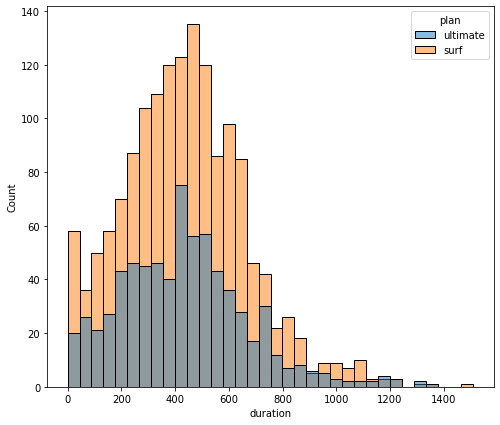

The overall average for duration is: 436
The variance for duration is: 232
The standard deviation for duration is: 232
The averages per plan:
plan
surf        436.519741
ultimate    434.676017
Name: duration, dtype: float64
Values are centered around the average


In [137]:
users_stat('duration')

The distributions of call duration for the plans are similar. The average duration 436 for surf and 434 for ultimate. It seems that the user call behavior for both plans was similar even though surf users required more extra minutes.

Let's plot a boxplot to visualize the distribution of the monthly call duration for each plan.

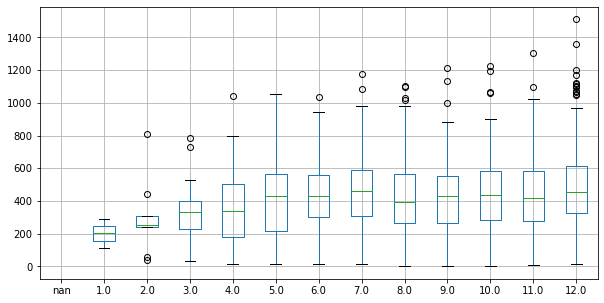

In [138]:
# Plotting a boxplot to visualize the distribution of the monthly call duration for surf

surf.pivot(values='duration', columns='month').boxplot(figsize=(10,5))
plt.show()

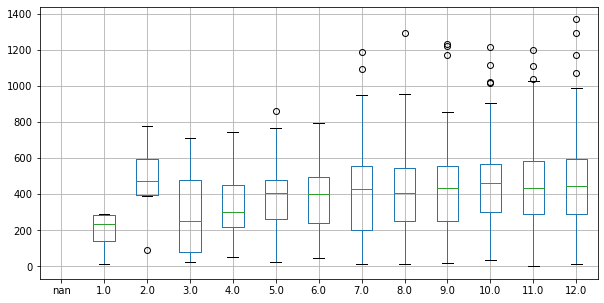

In [139]:
# Plotting a boxplot to visualize the distribution of the monthly call duration for ultimate

ultimate.pivot(values='duration', columns='month').boxplot(figsize=(10,5))
plt.show()

The boxplots for surf and ultimate users are similar across monthly call duration, indicating similar user call behavior between the plans.

The distributions of call duration for the plans are similar. The average duration 436 for surf and 434 for ultimate. It seems that the user call behavior for both plans was similar even though surf users required more extra minutes.

### Messages

Let's explore message usage per plan per month.

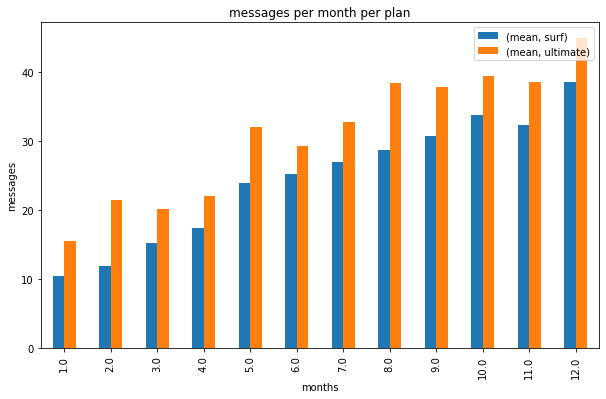

In [140]:
# Comparing the number of messages users of each plan tend to send each month

users.pivot_table(index='month',columns='plan', values = 'message_id', aggfunc=['mean']).plot(kind='bar', figsize=(10, 6))

plt.xlabel("months")
plt.ylabel("messages")
plt.title("messages per month per plan")
plt.legend(loc='upper right')
plt.show()

The plot shows that both surf and ultimate users tended to increase the number of messages sent per month as the year progressed. Ultimate users seem to send more messages on average. We will explore this further with a statistical analysis.

Let's compare the  number of extra messages users of each plan require each month. We will need to calculate the number of extra messages above the standard minutes included in the plan and create a column for these messages. We will then plot a histogram displaying the messages required for each plan.

In [141]:
# Creating a column for 'messages_required' using a function

def xmessages(users):

    for user_id in users:
     
        if (users['message_id'] > users['messages_included']):
            xmessages = (users['message_id'] - users['messages_included'])
        else:
            xmessages = 0

        return round(xmessages)

In [142]:
# Applying 'xmessages' function to users and creating a column 'xmessages' to store the data
users['xmessages'] = users.apply(xmessages, axis=1)

Now we have an 'xmessages' column in users with a record of how many extra messages each user needed per month. Let's plot this data per plan.

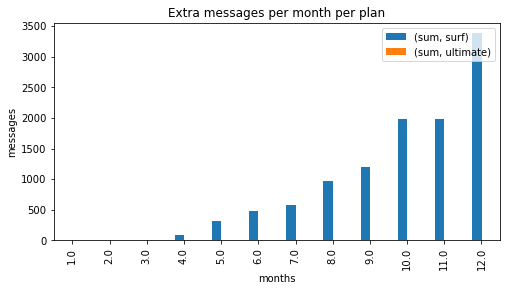

In [143]:
# Plotting 'xmessages' per month per plan using barplot

users.pivot_table(index='month',columns='plan', values ='xmessages', aggfunc=['sum']).plot(kind='bar', figsize=(8, 4))

plt.xlabel("months")
plt.ylabel("messages")
plt.title("Extra messages per month per plan")
plt.legend(loc='upper right')
plt.show()

The extra messages required per month was different for each plan. For surf, an increasing number of extra messages were required as the year progressed from January to December. Yet, ultimate users generally did not need extra messages. This makes sense since ultimate users had 1000 messages included on the standard plan, while surf had only 50 messages.

Let's use a histogram to plot the frequency of these values for x per plan and check the distribution. We will create a function to plot these histograms.

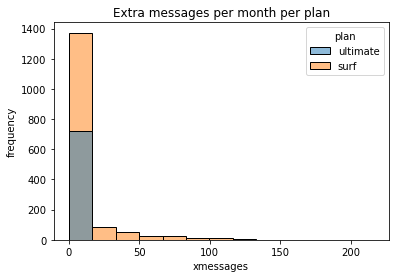

In [144]:
# Plotting the variance of 'xmessages' per plan using a histogram

sns.histplot(users, x='xmessages', hue='plan')
plt.xlabel("xmessages")
plt.ylabel("frequency")
plt.title("Extra messages per month per plan")
plt.show()

There was a big difference between extra messages required for each plan. The surf plan members tended to require more extra messages than ultimate users. Surf users mostly used less than 25 extra messages but they may have used over 100 extra messages. However, ultimate users who required extra messages tended to need less than 25 messages.

Let's explore messages further. We will plot a histogram for messages and calculate the mean and the variation of messages to explore whether users on the different plans have different behaviours for their message usage.

In [145]:
 # Calculate the mean and the variance of message usage

def users_stat(variable):
    fig, ax = plt.subplots(figsize=(8,7))
    ax = sns.histplot(users, x=variable, hue='plan')
    plt.show()
 
    mean=round(users[variable].mean())
    std=round(users[variable].std())
    var=round(users[variable].std())
    cv=std/mean # Coeeficient of variation


    print('The overall average for', variable, 'is:', mean)
    print('The variance for', variable, 'is:', var)
    print('The standard deviation for', variable, 'is:', std)
    print('The averages per plan:')
    print(users.groupby(['plan'])[variable].mean())
    if cv>1:
        print('Values vary a lot')
    else:
        print('Values are centered around the average')

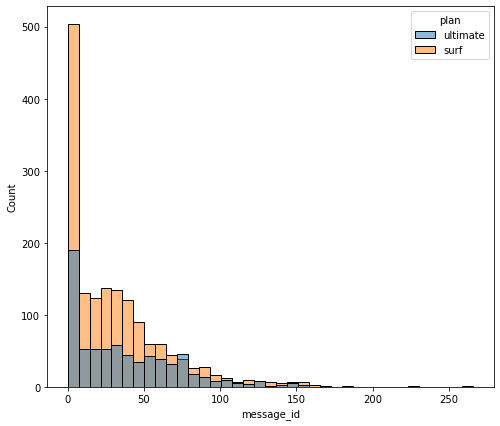

The overall average for message_id is: 33
The variance for message_id is: 34
The standard deviation for message_id is: 34
The averages per plan:
plan
surf        31.041165
ultimate    37.343923
Name: message_id, dtype: float64
Values vary a lot


In [146]:
users_stat('message_id')

There was a difference in message behavior between the plans. The mean for messages sent was 30 for surf and 37 for ultimate. Overall, ultimate users tended to send more mesages than surf users per month.
Let's plot a boxplot to visualize the distribution of monthly messages for each plan.

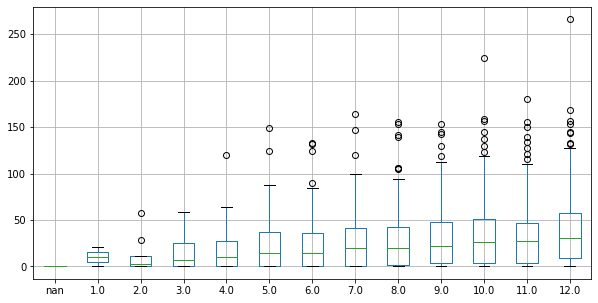

In [147]:
# Plotting a boxplot to visualize the distribution of the monthly call duration for surf

surf.pivot(values='message_id', columns='month').boxplot(figsize=(10,5))
plt.show()

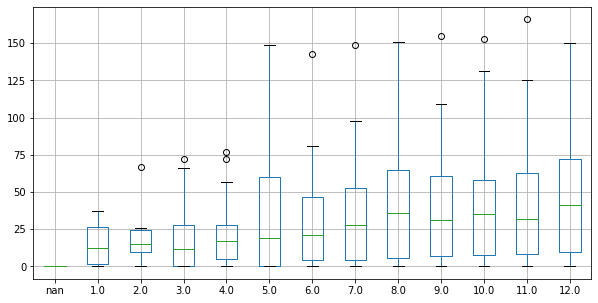

In [148]:
# Plotting a boxplot to visualize the distribution of the monthly call duration for ultimate

ultimate.pivot(values='message_id', columns='month').boxplot(figsize=(10,5))
plt.show()

The boxplots for surf and ultimate users are different across monthly call duration, indicating that ultimate users tend to send more messages per month than surf users.

### Internet

Let's explore internet usage per plan per month.

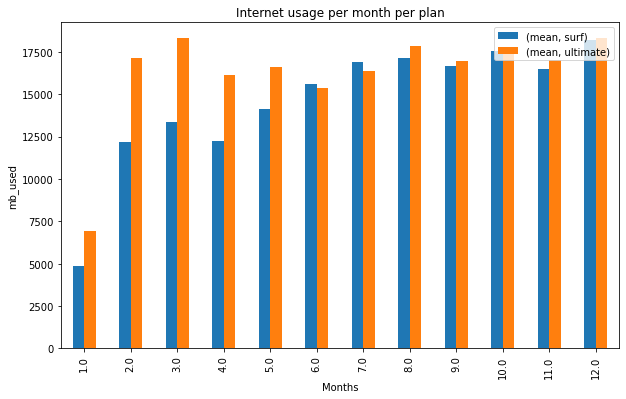

In [149]:
# Compare the amount of internet traffic consumed by users per plan

users.pivot_table(index='month',columns='plan', values = 'mb_used', aggfunc=['mean']).plot(kind='bar', figsize=(10, 6))

plt.xlabel("Months")
plt.ylabel("mb_used")
plt.title("Internet usage per month per plan")
plt.legend(loc='upper right')
plt.show()

The amount of internet used (mb_used) varied per month. Less internet was used in January compared to other months. Ultimate users tended to use slightly more internet than surf users, but there did not seem to be a significant difference in internet usage between the plans. We will check this further with statistical analysis.

Let's compare the  number of extra gb users of each plan require each month. We already created a column gb_used indicating the extra internet a user required per month. We will use this to plot a histogram displaying the gb required for each plan.

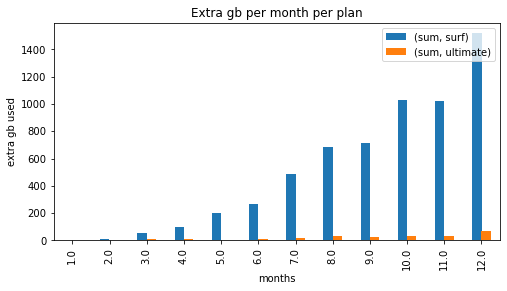

In [150]:
# Plotting 'gb_used' per month per plan using barplot

users.pivot_table(index='month',columns='plan', values ='gb_used', aggfunc=['sum']).plot(kind='bar', figsize=(8, 4))

plt.xlabel("months")
plt.ylabel("extra gb used")
plt.title("Extra gb per month per plan")
plt.legend(loc='upper right')
plt.show()

The distribution of extra internet required per month was similar for both plans in that the internet required tended to increase per month as the year progressed. However, extra internet usage differed between plans, such that surf users required more extra internet than ultimate users.  This makes sense since ultimate users had 30 GB included on the standard plan, while surf had only 15 GB included.

Let's use a histogram to plot the frequency of these values for x per plan and check the distribution. We will create a function to plot these histograms.

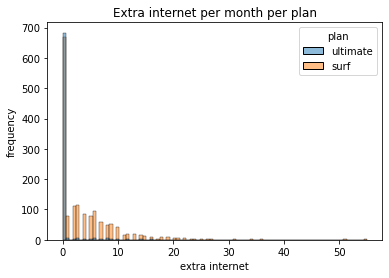

In [151]:
# Plotting the variance of 'xgb' per plan using a histogram

sns.histplot(users, x='gb_used', hue='plan')
plt.xlabel("extra internet")
plt.ylabel("frequency")
plt.title("Extra internet per month per plan")
plt.show()

There is a big difference between extra internet data required for each plan. The surf plan members tendedto require more extra GB than ultimate users. The distribution of users requiring higher amounts of GB was skewed towards the higher end for surf users than for ultimate users.

Let's explore internet usages further. We will plot a histogram for internet usage and calculate the mean and the variation of internet usage to explore whether users on the different plans have different behaviours for their internet usage.

In [152]:
 # Calculate the mean and the variance of the internet usage

def users_stat(variable):
    fig, ax = plt.subplots(figsize=(8,7))
    ax = sns.histplot(users, x=variable, hue='plan')
    plt.show()
 
    mean=round(users[variable].mean())
    std=round(users[variable].std())
    var=round(users[variable].std())
    cv=std/mean # Coeeficient of variation


    print('The overall average for', variable, 'is:', mean)
    print('The variance for', variable, 'is:', var)
    print('The standard deviation for', variable, 'is:', std)
    print('The averages per plan:')
    print(users.groupby(['plan'])[variable].mean())
    if cv>1:
        print('Values vary a lot')
    else:
        print('Values are centered around the average')

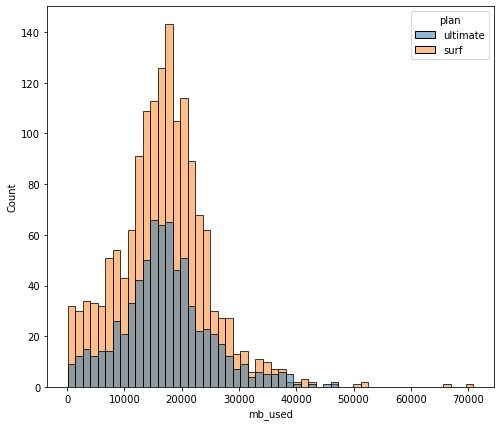

The overall average for mb_used is: 16882
The variance for mb_used is: 7870
The standard deviation for mb_used is: 7870
The averages per plan:
plan
surf        16717.702137
ultimate    17238.642253
Name: mb_used, dtype: float64
Values are centered around the average


In [153]:
users_stat('mb_used')

The distributions for internet usage were similar across the plans. The mean mb used for surf users were 16717 and 17238 for ultimate. There was a normal distribution of internet usage across the plans.
Let's plot a boxplot to visualize the distribution of monthly internet usage for each plan.

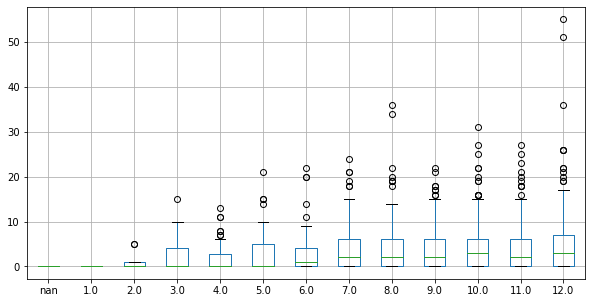

In [154]:
# Plotting a boxplot to visualize the distribution of the monthly call duration for surf

surf.pivot(values='gb_used', columns='month').boxplot(figsize=(10,5))
plt.show()

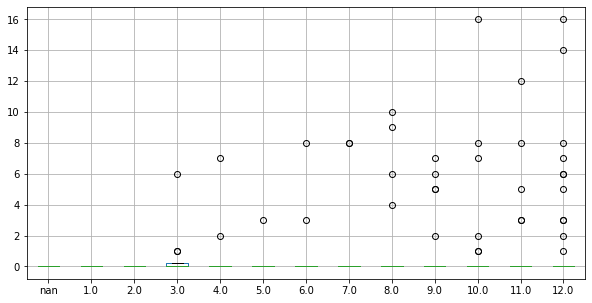

In [155]:
# Plotting a boxplot to visualize the distribution of the monthly call duration for ultimate

ultimate.pivot(values='gb_used', columns='month').boxplot(figsize=(10,5))
plt.show()

The boxplots for surf and ultimate users have a similar distribution, with users tending to have a lower range of internet usage in the months of January and February and higher ranges as the year progressed. Internate usage by ultimate users had a higher range than for surf users, yet the averages of users of both plans tended to be similar per month. There was a slightly higher internet usage for ultimate users than surf users yet this difference is not significant.

## Revenue

Let's explore the difference in revenue between the plans.

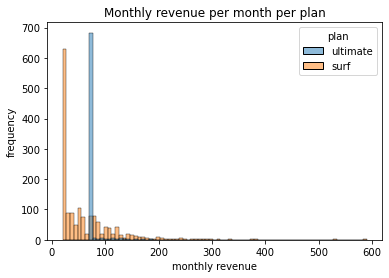

In [156]:
# Plotting the variance of call revenue per plan

sns.histplot(users, x='monthly_revenue', hue='plan')
plt.xlabel("monthly revenue")
plt.ylabel("frequency")
plt.title("Monthly revenue per month per plan")
plt.show()

The distribution of monthly revenue seems skewed to the right for ultimate users, indicating an average higher revenue from ultimate surf users. We will explore this further to see if this difference is statistically significant. 

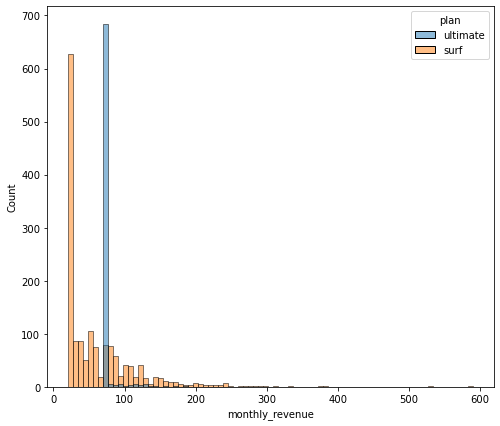

The overall average for monthly_revenue is: 64
The variance for monthly_revenue is: 47
The standard deviation for monthly_revenue is: 47
The averages per plan:
plan
surf        60.551729
ultimate    72.301105
Name: monthly_revenue, dtype: float64
Values are centered around the average


In [157]:
 # Calculate the mean and the variance of revenue

users_stat('monthly_revenue')

The distributions of revenue was normal for both plans. Yet, there was a higher revenue from ultimate users than surf users. The mean monthly revenue was 61 for surf users and 72 was for ultimate users.
Let's explore the monthly revenue between plans using a box plot.

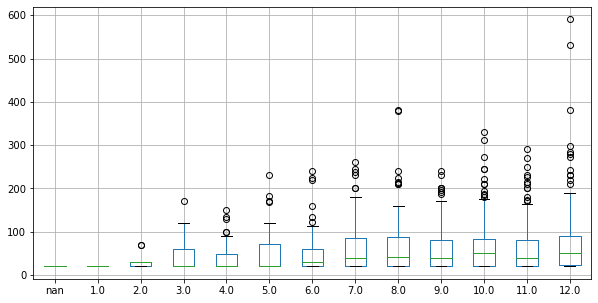

In [158]:
surf.pivot(values='monthly_revenue', columns='month').boxplot(figsize=(10,5))
plt.show()

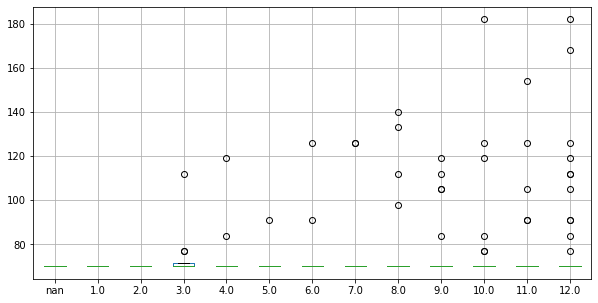

In [159]:
ultimate.pivot(values='monthly_revenue', columns='month').boxplot(figsize=(10,5))
plt.show()

The monthly revenue differed between plans, such that ultimate users tended to generate more monthly revenue than surf users. 

## Test Statistical Hypotheses

We have analyzed the differences in usage between the plans. Let's test hypotheses to investigate if the differences in revenue between the plans are statistically significant.
The null hypotheses: The average revenue for users of ultimate and surf do not differ.
The alternative hypothesis: The average revenue for users of ultimate and surf differ.
We will use a ttest_ind since there are two independent samples.
We will use an alpha level of 0.01, a strict measure of statistical significance.

Let's use Levene’s test to check that variances are equal before we test our hypothesis. We will use an alpha level of 0.01.

In [160]:
p_value_Levene=stats.levene(ultimate['monthly_revenue'], surf['monthly_revenue'], center='median').pvalue
p_value_Levene

3.070976609395645e-83

The p-value of Levene's test is close to zero and below an alpha level of 0.01, the samples are not equal in variance. We will indicate this in the equal_var parameter of our t-test.

In [161]:
# Creating a function to test the hypothesis using a t-test 

def ttest(sample1, sample2):

    alpha = 0.01
    results = stats.ttest_ind(sample1,sample2, equal_var= False)

    print('p-value: ', results.pvalue) 

    if results.pvalue < alpha:
        print('We reject the null hypothesis')
    else:
        print("We can't reject the null hypothesis")

In [162]:
ttest(ultimate['monthly_revenue'], surf['monthly_revenue'])

p-value:  1.218411585212325e-15
We reject the null hypothesis


The p-value for our test was close to zero, indicating that the chances of obtaining this result by chance is close to zero. This indicates that we need to reject the null hypothesis. There was a statistically significnt difference in revenue between plans.

Let's compare the average revenue from users in the NY-NJ area and users from other regions. We will slice the data of NY-NJ users and other users and compare these dataframes to see if they differ.

In [163]:
# Using str.contains to get the users in NY-NJ vs not.

NY_NJ_users = users[users['city'].str.contains('NY|NJ')]
other_users = users[~users['city'].str.contains('NY|NJ')]

The null hypotheses: The average revenue for users from NY/NJ and other users do not differ.
The alternative hypothesis: The average revenue for users from NY/NJ and other users differ.
We will use a ttest_ind since there are two independent samples.
We will use an alpha level of 0.01, a strict measure of statistical significance.
Let's use Levene's test to check if the variance of the samples are equal. If they are not equal we will use the function created for the t-test above.

In [164]:
p_value_Levene=stats.levene(NY_NJ_users['monthly_revenue'], other_users['monthly_revenue'], center='median').pvalue
p_value_Levene

0.0017242670853101626

The p-value of Levene's test is less than the alpha level of 0.01 so we will indicated unequal variance in the t-test. Let's apply the function for the t-test.

In [165]:
ttest(NY_NJ_users['monthly_revenue'], other_users['monthly_revenue'])

p-value:  0.12126002617160894
We can't reject the null hypothesis


The p-value was 0.12, which is above the alpha level of 0.1 and even above an alpha level of 0.05. So we cannot reject the null hypothesis that there is no significant difference between users from NY/NJ and other users.

## General Conclusion

We used four dataframes five our analyses: plans_data, users_data, calls_data, messages_data, and internet_data. Prior to our analyses, we preprocessed the data in each dataframe. 
For plans_data, we added a column 'gb_per_month_included' to the plans dataframe to make it easier to calculate monthly revenue using gb for our analysis. We also renamed the column ‘plan_name’ to ‘plan’ to make it easier to merge the dataframes.

For users_data,  we converted reg_date and churn_date to datetime types.

For calls_data, we renamed ‘id’ to ‘caller_id’ to easily identify it after creating a merged dataframe later on. We converted the call_date to a datetime type. We also changed ‘duration’ to an integer type after rounding each number up to the nearest minute, since megaline rounds call duration up to the nearest minute. We also create a column for ‘month’ to analyze call behavior per month for future analysis.

For messages_data, we renamed the column ‘id’ to ‘message_id’ to easily identify it after creating a merged dataframe. We also converted message_date to a datetime type. We also create a column for ‘month’ to analyze call behavior per month for future analysis.

For internet_data, we converted ‘session_date’ to a datetime type. We created a column for ‘month’ to analyze call behavior per month for future analysis.

After preprocessing the data, we aggregated the data on user call, message and internet usage by grouping by month and user id. We, then, merged the data in these tables with user info and plans info to create one dataframe with user specific information.

After merging the data, we filled in missing values in the message_id column with zeros to indicate where there was no usage.

We created a column 'gb_used' to calculate extra internet usage per month for future analysis. We rounded the values in gb_used up and converted it to an integer. 

We created a function to calculate monthly revenue.

After processing the data, we studied user behavior. There were several interesting observations:

For call usage:
The average duration of calls per month varied across months for each plan. The mean duration tended to get higher from January to December for both plans. However, the average duration of calls for 'ultimate' was particularly high for February.  Yet, the mean call duration for ultimate users was 434 and the median was 425. The mean call duration for surf users was 436 and the median was 430. These mean and median values per plan are close so it appeared that the distribution of values for call duration was not significantly affected by outliers.

The extra minutes required per month were different for each plan. For surf, an increasing number of extra minutes were required as the year progressed from January to December. There was a big difference between extra minutes required for each plan. The surf plan members tended to require more extra minutes than ultimate users. Surf users mostly used less than 200 extra minutes but they may have used over 700 extra minutes. However, ultimate users who require extra minutes tended to need less than 100 minutes. Ultimate users generally did not need extra minutes. This makes sense since ultimate users had 3000 minutes included on the standard plan, while surf had only 500 minutes.

The distributions of call duration for the plans were similar. The average duration 436 for surf and 434 for ultimate. It seems that the user call behavior for both plans was similar even though surf users required more extra minutes.

For message usage:

Both surf and ultimate users tended to increase the number of messages sent per month as the year progressed. Ultimate users seem to send more messages on average.

The extra messages required per month was different for each plan. For surf, an increasing number of extra messages were required as the year progressed from January to December. 
There was a big difference between extra messages required for each plan. The surf plan members tended to require more extra messages than ultimate users. Surf users mostly used less than 25 extra messages but they may have used over 100 extra messages. However, ultimate users who required extra messages tended to need less than 25 messages. Ultimate users generally did not need extra messages. This makes sense since ultimate users had 1000 messages included on the standard plan, while surf had only 50 messages.

There was a difference in message behavior between the plans. The mean for messages sent was 30 for surf and 37 for ultimate. Overall, ultimate users tended to send more mesages than surf users per month.

For internet usage:

The amount of internet used (mb_used) varied per month. Less internet was used in January compared to other months. Ultimate users tended to use slightly more internet than surf users, but there did not seem to be a significant difference in internet usage between the plans.

The distribution of extra internet required per month was similar for both plans in that the internet required tended to increase per month as the year progressed. However, extra internet usage differed between plans, such that surf users required more extra internet than ultimate users.  This makes sense since ultimate users had 30 GB included on the standard plan, while surf had only 15 GB included.

The distributions for internet usage were similar across the plans. The mean mb used for surf users were 16717 and 17238 for ultimate. There was a normal distribution of internet usage across the plans.  Internate usage by ultimate users had a higher range than for surf users, yet the averages of users of both plans tended to be similar per month. There was a slightly higher internet usage for ultimate users than surf users yet this difference is not significant.

For monthly revenue:
The monthly revenue differed between plans, such that ultimate users tended to generate more monthly revenue than surf users. The distributions of revenue was normal for both plans. Yet, there was a higher revenue from ultimate users than surf users. The mean monthly revenue was 61 for surf users and 72 for ultimate users.

We tested the hypotheses to investigate if the differences in revenue between the plans are statistically significant.
The null hypotheses: The average revenue for users of ultimate and surf do not differ.
The alternative hypothesis: The average revenue for users of ultimate and surf differ.
We used a ttest_ind since there were two independent samples.
We used an alpha level of 0.01, a strict measure of statistical significance.
The p-value for our test was close to zero, indicating that the chances of obtaining this result by chance is close to zero. This indicates that we need to reject the null hypothesis. There was a statistically significant difference in revenue between plans.

We tested the hypotheses to compare the average revenue from users in the NY-NJ area and users from other regions.
The alternative hypothesis: The average revenue for users from NY/NJ and other users differ.
We used a ttest_ind since there were two independent samples.
We used an alpha level of 0.01, a strict measure of statistical significance.
The p-value was 0.12, which was above the alpha level of 0.1 and even above an alpha level of 0.05. So we cannot reject the null hypothesis that there is no significant difference between users from NY/NJ and other users.